# Unsupervisws Morphological Analysis - Lexicons with freequency counted


In [11]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

#from importlib import reload  # Python 3.4+

import pickle
import pandas as pd

#force reimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']
if 'pygents.token_plot' in sys.modules:
    del sys.modules['pygents.token_plot']


from pygents.token import *
from pygents.text import *
from pygents.util import *
from pygents.plot import plot_bars, plot_dict, matrix_plot
from pygents.token_plot import *

## Load lexicons

In [12]:
#get raw lexicon list
ru_lex = list(pd.read_csv("https://raw.githubusercontent.com/aigents/aigents-java/master/lexicon_russian.txt",sep='\t',header=None,na_filter=False).to_records(index=False))
print(len(ru_lex))

#debug raw lexicon
print(max(ru_lex,key=lambda item:item[1]))
ru_lex_dict = weightedlist2dict(ru_lex,lower=True) # no case-insensitive merge
print(len(ru_lex_dict))


99983
('не', 3164900)
91379


In [13]:
#get raw lexicon list
en_lex = list(pd.read_csv("https://raw.githubusercontent.com/aigents/aigents-java/master/lexicon_english.txt",sep='\t',header=None,na_filter=False).to_records(index=False))
print(len(en_lex))

#debug raw lexicon
print(max(en_lex,key=lambda item:item[1]))
en_lex_dict = weightedlist2dict(en_lex,lower=True) # no case-insensitive merge
print(len(en_lex_dict))


97565
('the', 53097401)
97565


In [17]:
en_lex_dict['the']

53097401

In [19]:
for text in en_lex_dict:
    print(text,en_lex_dict[text])
    break

the 53097401


In [22]:
ll = 
for text in ll:
    print(text,ll[text])
    break

TypeError: list indices must be integers or slices, not str

In [23]:
def test(texts):
    for text in texts:
        cnt = texts[text] if type(texts) == dict else 1
        print(text,cnt)


In [24]:
test(['eee','ss'])

eee 1
ss 1


In [26]:
test({'eee':7,'ss':8})


eee 7
ss 8


## Build word-level transition models (no count) 

91379
1008386


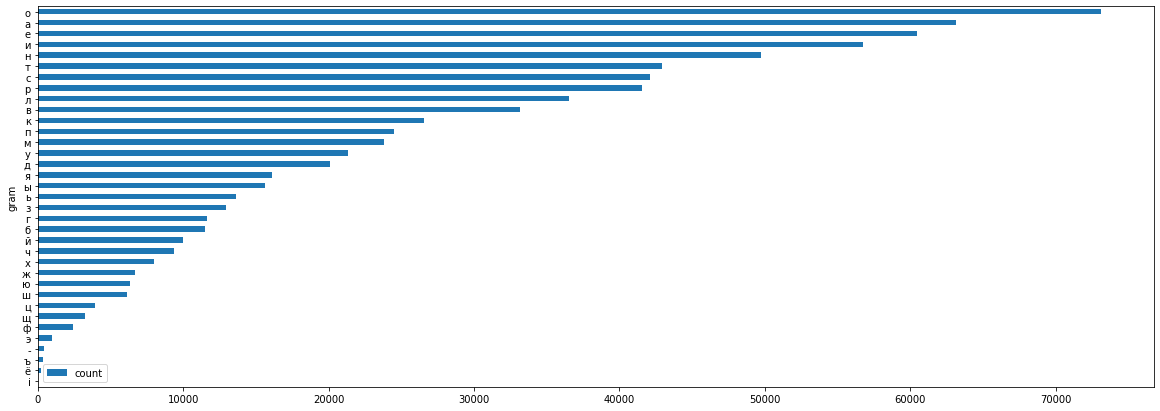

In [15]:
ru_lex_texts_no_count = list(ru_lex_dict)
print(len(ru_lex_texts_no_count))
lex_ru_base = FreedomTokenizer(max_n=7,mode='chars',debug=False)
lex_ru_base.train(ru_lex_texts_no_count)
lex_ru_base.store('data/models/lex_ru_nocount_7')
print(lex_ru_base.count_params())
dic = dict([(key,lex_ru_base.model[0][key]) for key in lex_ru_base.model[0] if len(key) == 1])
plot_dict(dic,'gram','count')


97565
1257863


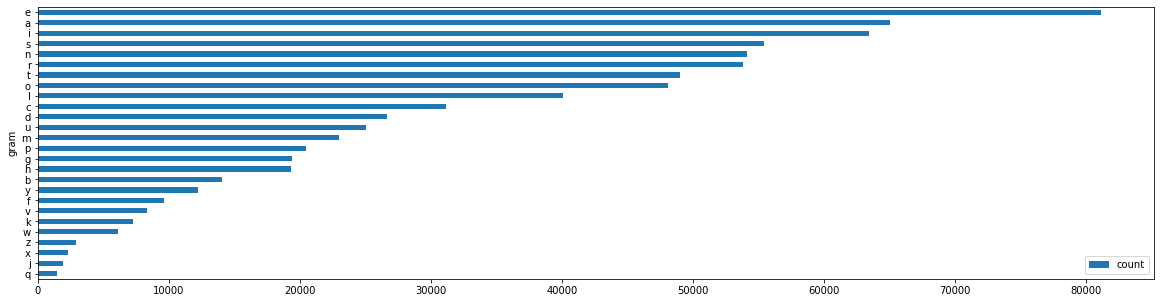

In [16]:
en_lex_texts_no_count = list(en_lex_dict)
print(len(en_lex_texts_no_count))
lex_en_base = FreedomTokenizer(max_n=7,mode='chars',debug=False)
lex_en_base.train(en_lex_texts_no_count)
lex_en_base.store('data/models/lex_en_nocount_7')
print(lex_en_base.count_params())
dic = dict([(key,lex_en_base.model[0][key]) for key in lex_en_base.model[0] if len(key) == 1])
plot_dict(dic,'gram','count')


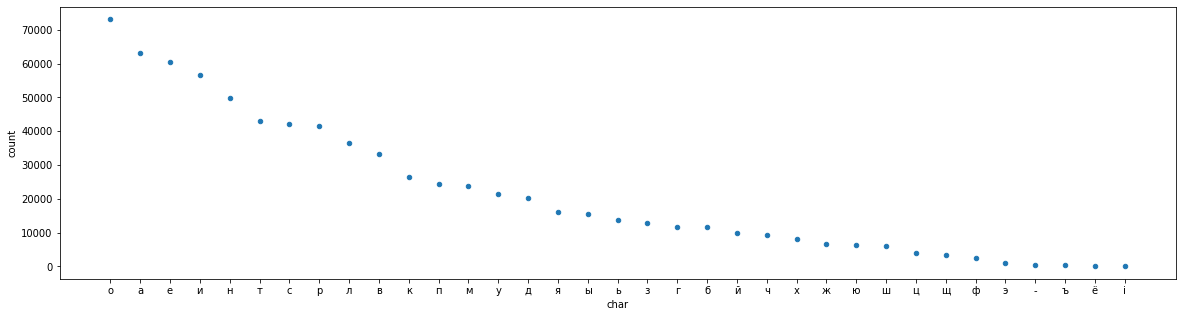

In [6]:
l = sorted([(key,lex_ru_base.model[0][key]) for key in lex_ru_base.model[0] if len(key) == 1],key=lambda x: x[1])
l.reverse()
df = pd.DataFrame(l,columns=['char','count'])
p = df.plot.scatter(x='char',y='count')


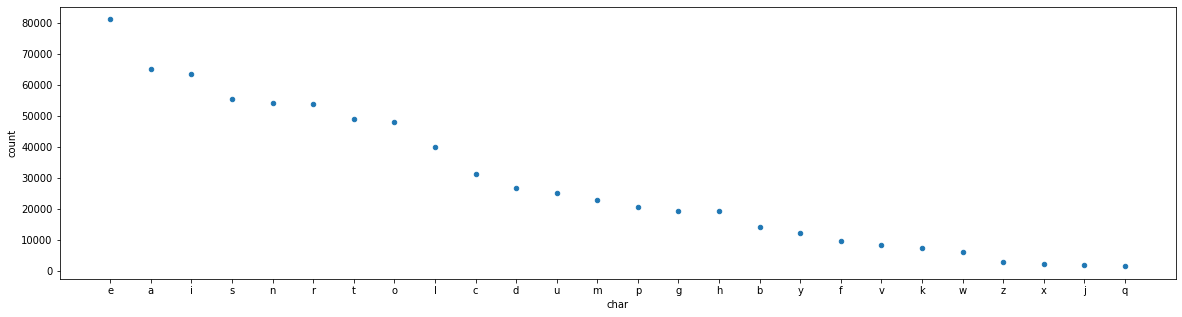

In [7]:
l = sorted([(key,lex_en_base.model[0][key]) for key in lex_en_base.model[0] if len(key) == 1],key=lambda x: x[1])
l.reverse()
df = pd.DataFrame(l,columns=['char','count'])
p = df.plot.scatter(x='char',y='count')


## Setup reference prefix/suffix-based morpho-parser 

In [8]:
en_ref_tokenizer = PrefixSuffixMorphoTokenizerCached(["./data/corpora/English/morphology/prefixes.txt"],
                                   ["./data/corpora/English/morphology/suffixes.txt"])


./data/corpora/English/morphology/prefixes.txt
./data/corpora/English/morphology/suffixes.txt


In [47]:
print(en_ref_tokenizer.tokenize('subsidiary'))
print(en_ref_tokenizer.tokenize('university'))
print(en_ref_tokenizer.tokenize('interestingly')) # TODO ['inter', 'est', 'ing', 'ly']


['sub', 'sidi', 'ary']
['uni', 'vers', 'ity']
['inter', 'esting', 'ly']


## Try morpho-parsing options for English

In [40]:
model_thresholds = [0,0.0001,0.001,0.01,0.1]
ngram_params = [[1],[2],[3],[4],[5],[6],[7]]
token_thresholds = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]


In [41]:
text = 'university'
base = FreedomTokenizer(name='data/models/lex_en_nocount_7',max_n=7,mode='chars',debug=False)
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    for ng in ngram_params:
        cnt = 0
        for tt in token_thresholds:
            tokenizer.set_options(nlist = ng, threshold=tt)
            t0 = en_ref_tokenizer.tokenize(text)
            t1 = tokenizer.tokenize(text)
            f1 = calc_f1(t0,t1)
            print(round(f1,2),t1,model_threshold,ng,tt)


0 ['universi', 'ty'] 0 [1] 0.001
0 ['universi', 'ty'] 0 [1] 0.01
0 ['universi', 'ty'] 0 [1] 0.1
0 ['universi', 'ty'] 0 [1] 0.2
0 ['universi', 'ty'] 0 [1] 0.3
0 ['universi', 'ty'] 0 [1] 0.4
0 ['universi', 'ty'] 0 [1] 0.5
0 ['universi', 'ty'] 0 [1] 0.6
0 ['universi', 'ty'] 0 [1] 0.7
0 ['universi', 'ty'] 0 [1] 0.8
0 ['universi', 'ty'] 0 [1] 0.9
0 ['un', 'i', 'v', 'e', 'r', 's', 'it', 'y'] 0 [2] 0.001
0 ['un', 'i', 'v', 'e', 'r', 's', 'it', 'y'] 0 [2] 0.01
0 ['un', 'i', 'v', 'e', 'r', 's', 'it', 'y'] 0 [2] 0.1
0 ['un', 'i', 'v', 'e', 'r', 's', 'it', 'y'] 0 [2] 0.2
0 ['un', 'i', 'v', 'e', 'r', 's', 'it', 'y'] 0 [2] 0.3
0 ['un', 'i', 'v', 'e', 'rs', 'it', 'y'] 0 [2] 0.4
0.22 ['uni', 'v', 'e', 'rs', 'it', 'y'] 0 [2] 0.5
0.5 ['uni', 'v', 'e', 'rs', 'ity'] 0 [2] 0.6
0.57 ['uni', 've', 'rs', 'ity'] 0 [2] 0.7
0.57 ['uni', 've', 'rs', 'ity'] 0 [2] 0.8
0.57 ['uni', 've', 'rs', 'ity'] 0 [2] 0.9
0 ['un', 'i', 'v', 'er', 's', 'it', 'y'] 0 [3] 0.001
0 ['un', 'i', 'v', 'er', 's', 'it', 'y'] 0 [3] 0.01
0

0 ['un', 'i', 'ver', 's', 'i', 'ty'] 0.001 [4] 0.2
0 ['un', 'i', 'ver', 's', 'i', 'ty'] 0.001 [4] 0.3
0 ['un', 'i', 'ver', 's', 'i', 'ty'] 0.001 [4] 0.4
0 ['un', 'i', 'ver', 's', 'i', 'ty'] 0.001 [4] 0.5
0 ['un', 'i', 'ver', 's', 'i', 'ty'] 0.001 [4] 0.6
0 ['un', 'i', 'ver', 's', 'i', 'ty'] 0.001 [4] 0.7
0 ['un', 'i', 'ver', 's', 'i', 'ty'] 0.001 [4] 0.8
0 ['un', 'iver', 's', 'i', 'ty'] 0.001 [4] 0.9
0.25 ['un', 'i', 'vers', 'i', 'ty'] 0.001 [5] 0.001
0.25 ['un', 'i', 'vers', 'i', 'ty'] 0.001 [5] 0.01
0.25 ['un', 'i', 'vers', 'i', 'ty'] 0.001 [5] 0.1
0.25 ['un', 'i', 'vers', 'i', 'ty'] 0.001 [5] 0.2
0.25 ['un', 'i', 'vers', 'i', 'ty'] 0.001 [5] 0.3
0.25 ['un', 'i', 'vers', 'i', 'ty'] 0.001 [5] 0.4
0.25 ['un', 'i', 'vers', 'i', 'ty'] 0.001 [5] 0.5
0.25 ['un', 'i', 'vers', 'i', 'ty'] 0.001 [5] 0.6
0 ['un', 'ivers', 'i', 'ty'] 0.001 [5] 0.7
0 ['un', 'ivers', 'i', 'ty'] 0.001 [5] 0.8
0 ['un', 'ivers', 'i', 'ty'] 0.001 [5] 0.9
0.22 ['u', 'n', 'i', 'vers', 'it', 'y'] 0.001 [6] 0.001
0.22 ['u

0.57 ['uni', 'vers', 'it', 'y'] 0.1 [7] 0.8
1.0 ['uni', 'vers', 'ity'] 0.1 [7] 0.9


## Test morpho-parsing options on small part of English lexicon

In [42]:
en_test_texts = [t for t in en_lex_texts_no_count if len(t) > 15][:10]
#en_test_texts = en_lex_texts_no_count

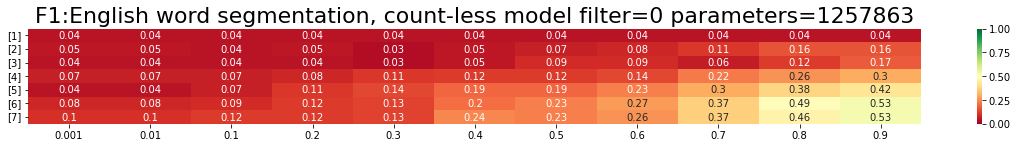

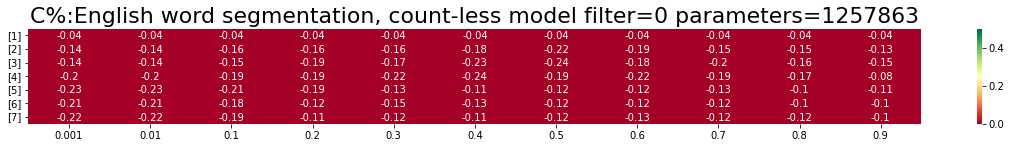

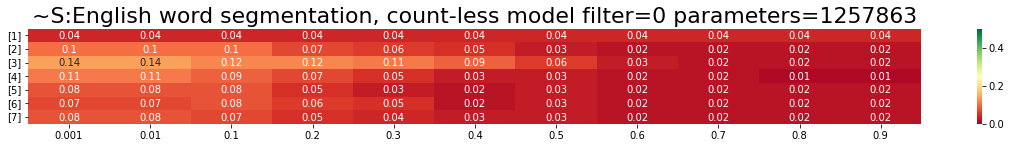

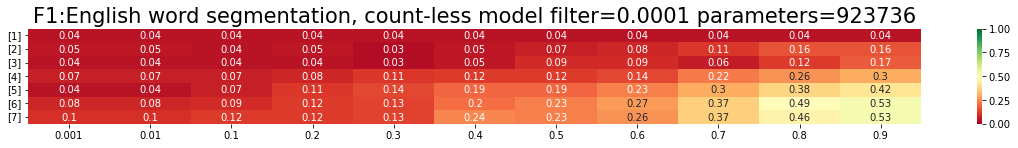

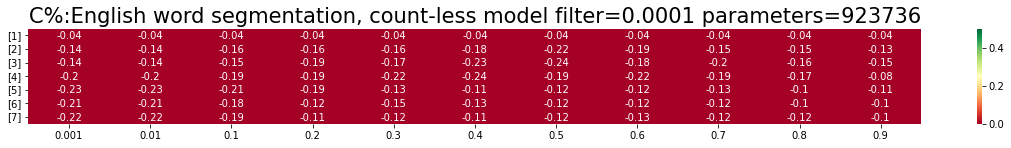

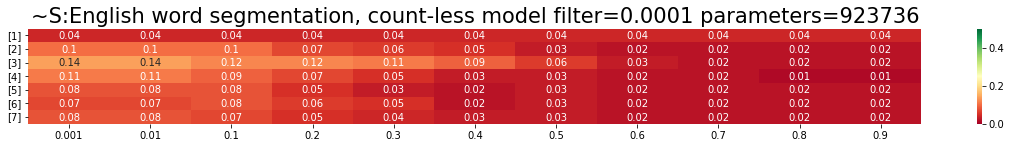

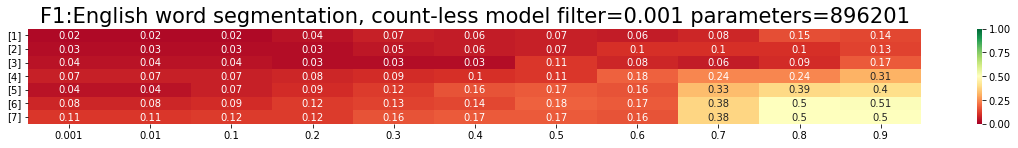

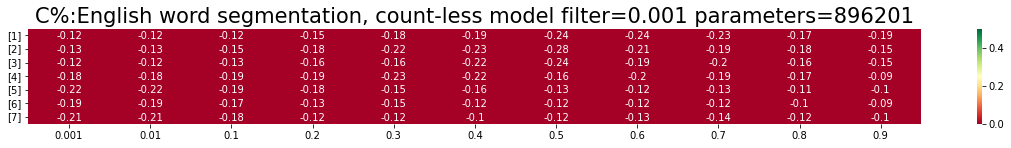

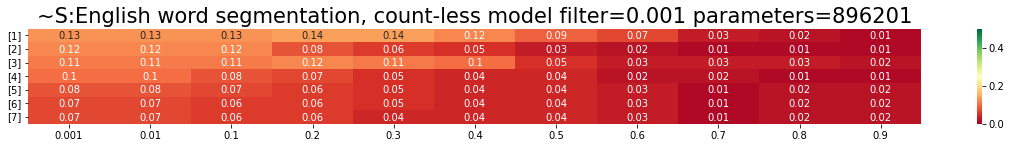

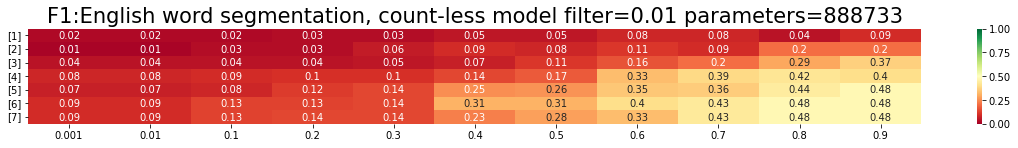

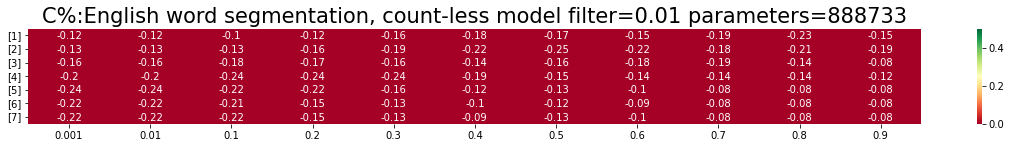

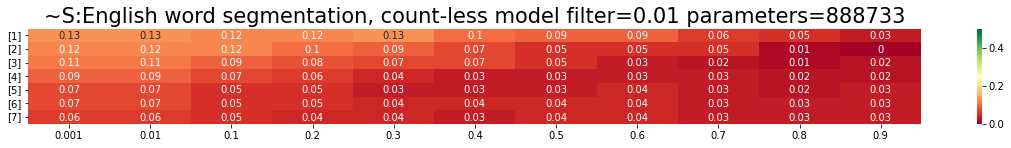

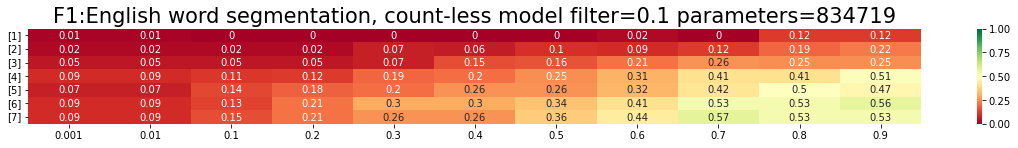

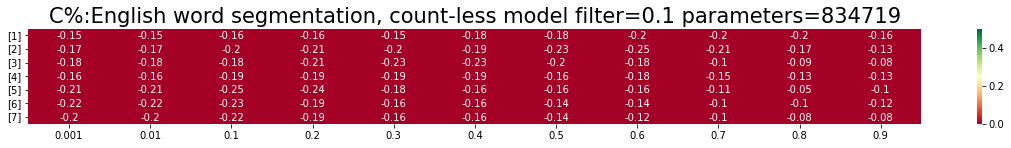

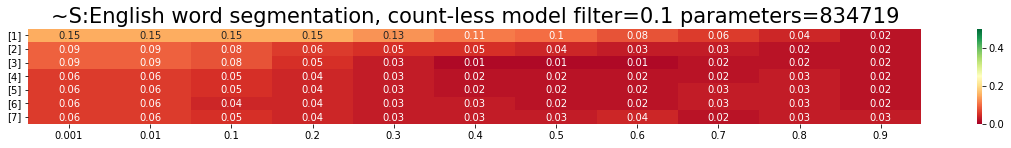

In [43]:
metrics_en_list = []

base = FreedomTokenizer(name='data/models/lex_en_nocount_7',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
    metrics_en_list.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


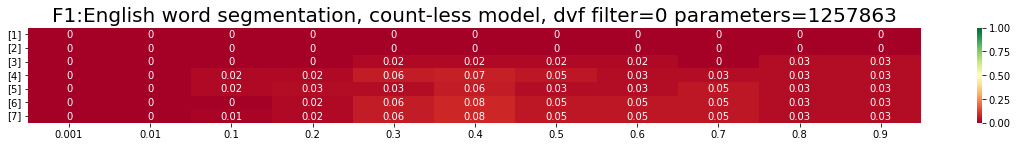

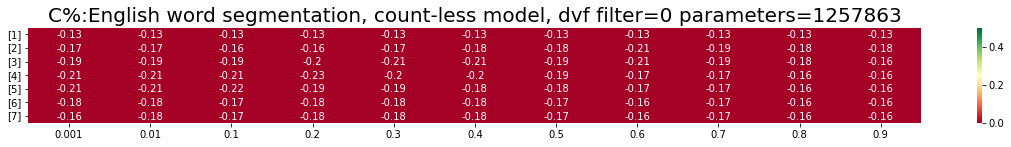

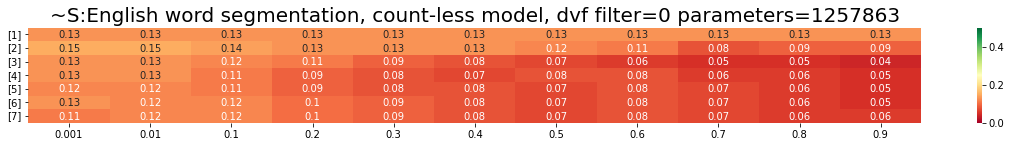

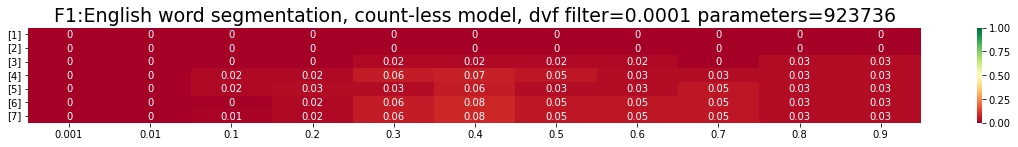

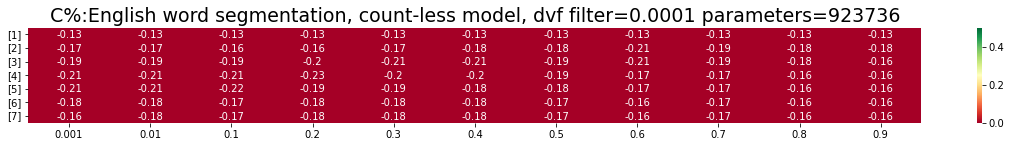

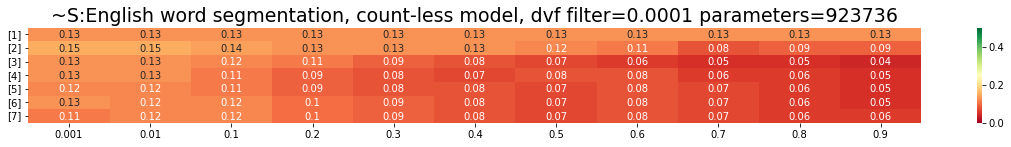

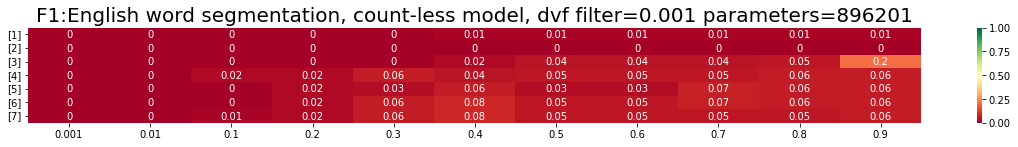

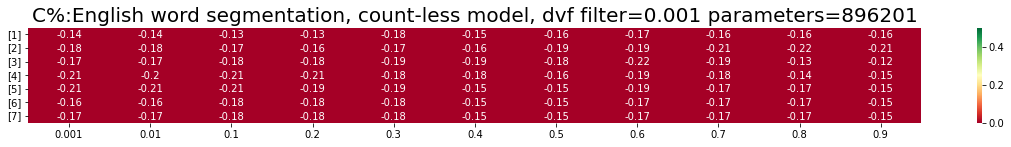

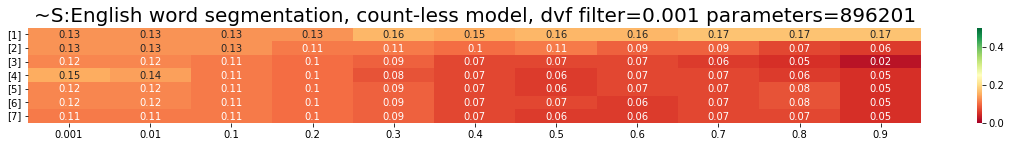

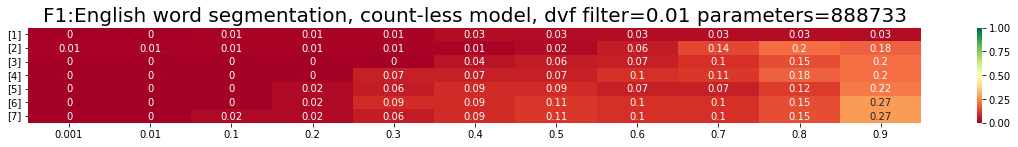

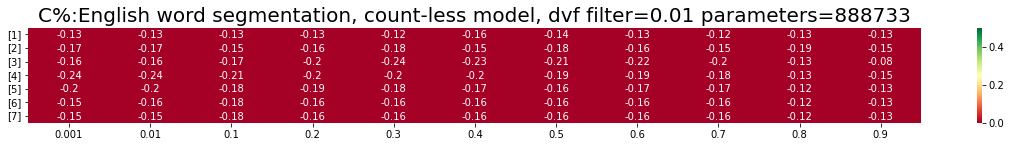

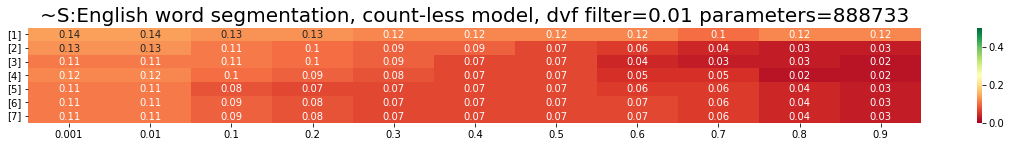

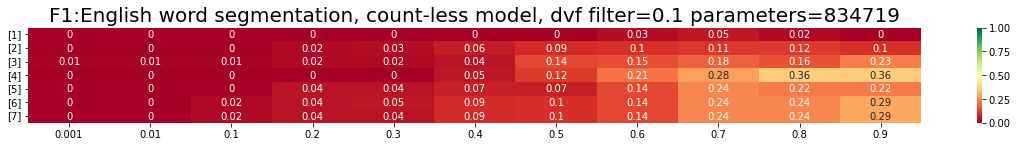

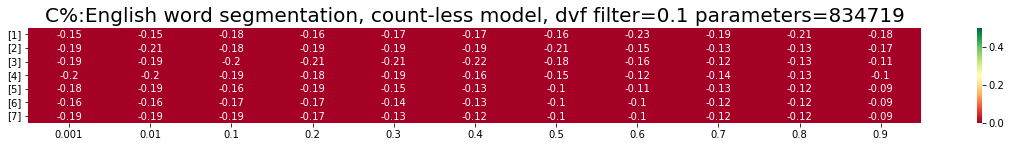

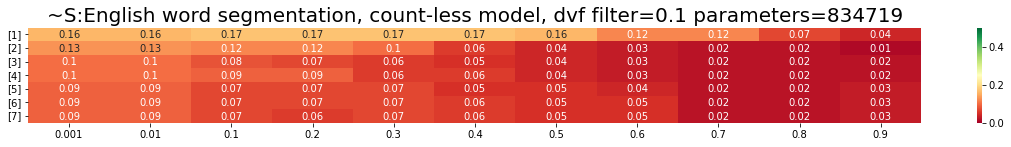

In [44]:
base = FreedomTokenizer(name='data/models/lex_en_nocount_7',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, dvf'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizer(base,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
    metrics_en_list.extend([('dvf',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


## Test morpho-parsing options on full English lexicon

In [ ]:
#en_test_texts = [t for t in en_lex_texts_no_count if len(t) > 15]
en_test_texts = en_lex_texts_no_count

metrics_en_list = []

base = FreedomTokenizer(name='data/models/lex_en_nocount_7',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
    metrics_en_list.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base
